<a href="https://colab.research.google.com/github/nuckleheadninja/ESEAI/blob/main/EseAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Model Evaluation:
RMSE: 41.92
R² Score: 0.90

--- Predict AQI for a City ---
Enter the name of the city: delhi


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

<ipython-input-29-ce80bd81b60a>:71: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.





Latest available pollution data for Delhi (on 2020-07-01):
PM2.5: 54.01
PM10: 128.66
NO2: 21.05
CO: 0.97
SO2: 11.15
O3: 29.73
NH3: 29.06

Predicted AQI for Delhi: 123.61


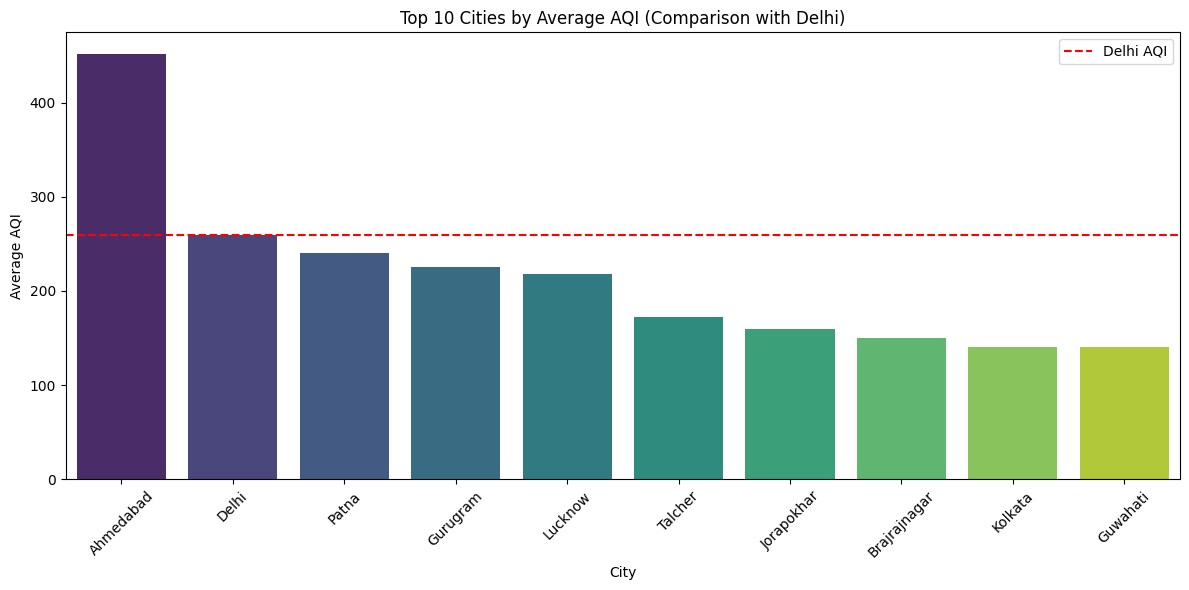

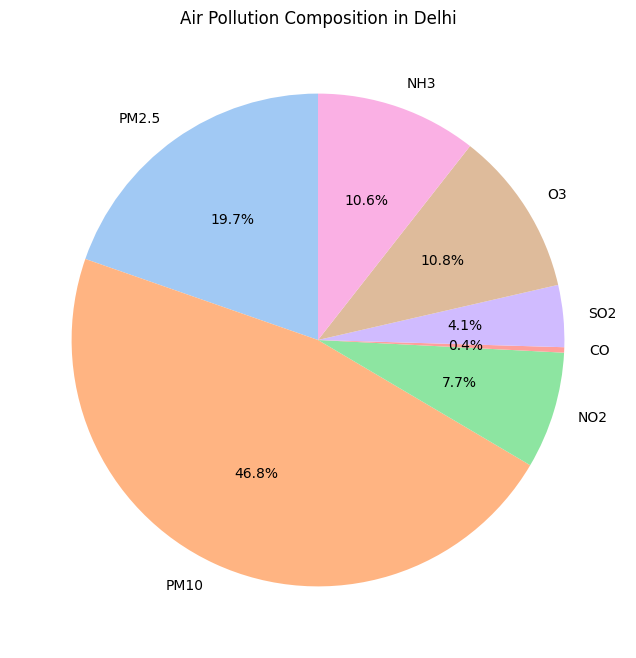

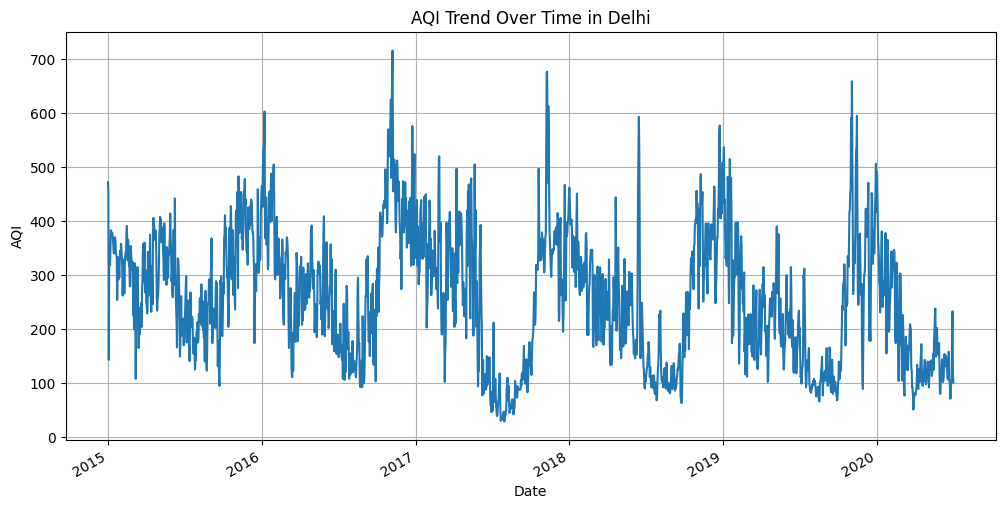

<ipython-input-29-ce80bd81b60a>:100: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




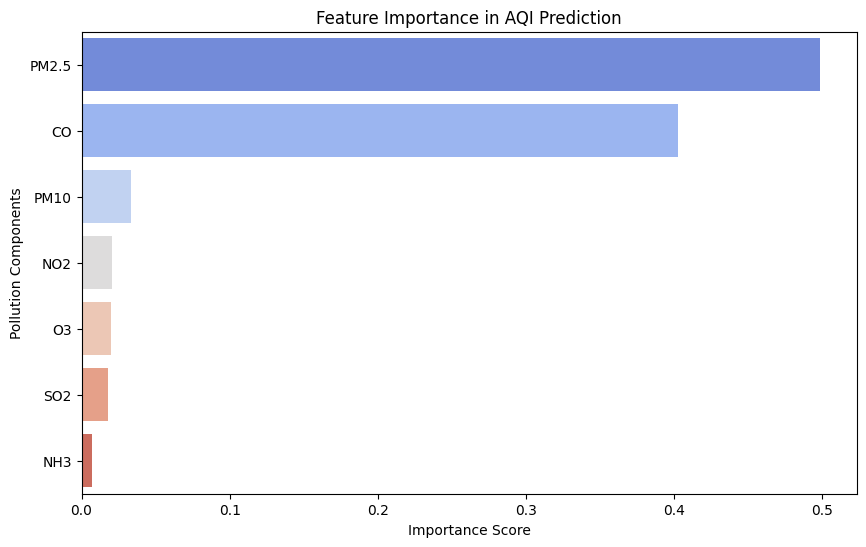

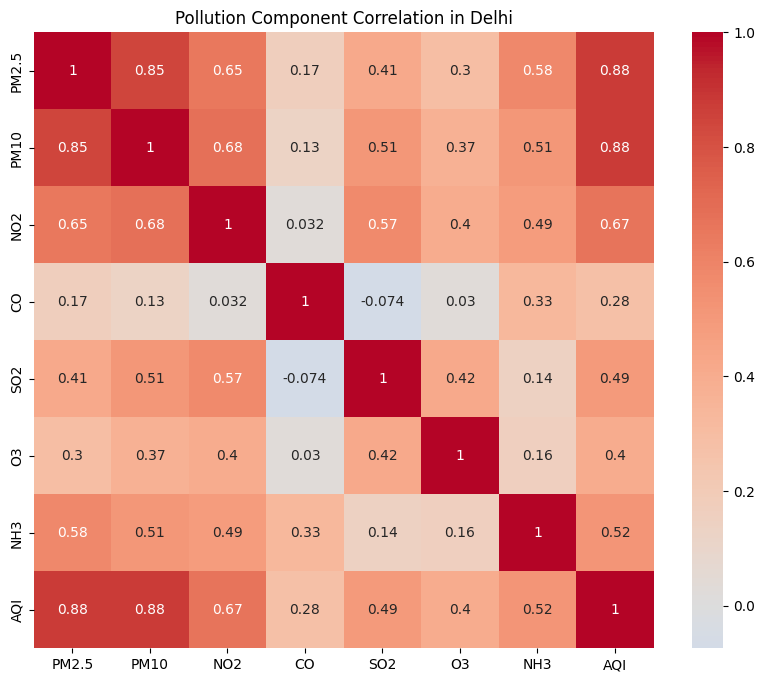

<ipython-input-29-ce80bd81b60a>:157: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




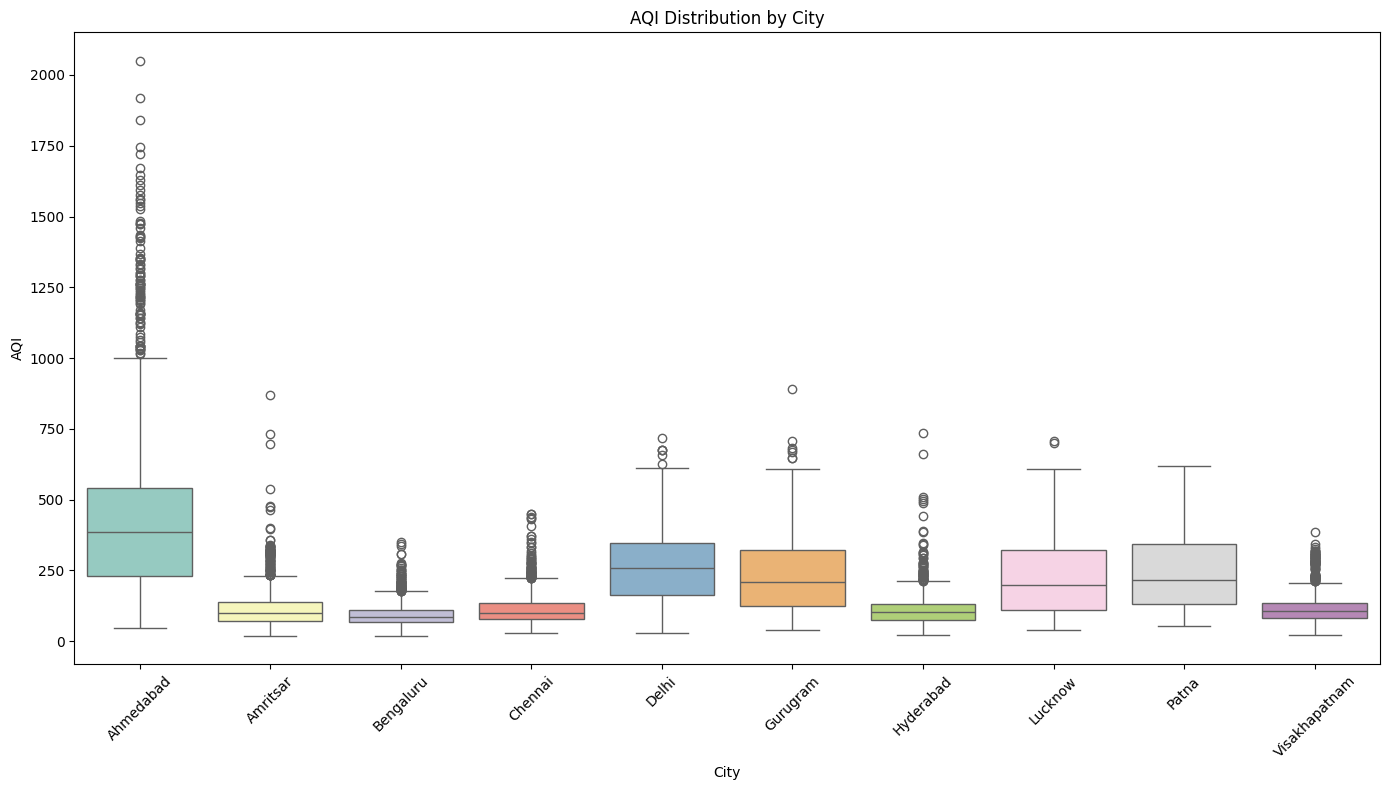

<ipython-input-29-ce80bd81b60a>:166: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




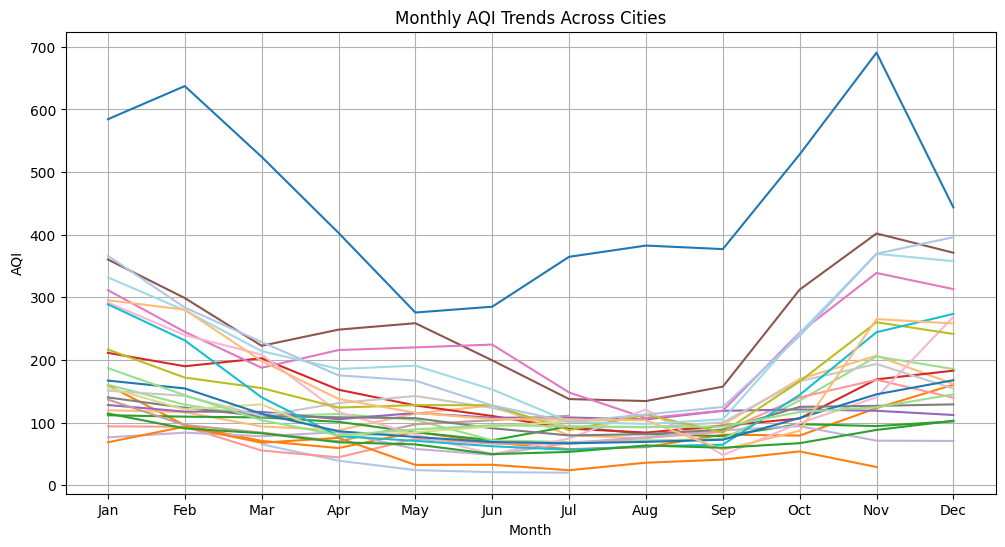

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Step 1: Load Data
df = pd.read_csv("/content/city_day.csv.zip")

# Step 2: Basic Cleaning
df = df.dropna(subset=['AQI'])  # Remove rows without AQI
df.fillna(0, inplace=True)      # Fill missing pollution values with 0

# Step 3: Feature Selection
features = ['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3', 'NH3']
X = df[features]
y = df['AQI']

# Step 4: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Scaling Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Train the Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Step 7: Predict & Evaluate
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Evaluation:")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Step 8: City-Based AQI Prediction and Visualizations
print("\n--- Predict AQI for a City ---")
city_input = input("Enter the name of the city: ").strip().title()

if city_input not in df['City'].unique():
    print("City not found in the dataset.")
    print("Available cities in the dataset:")
    print(df['City'].unique())
else:
    city_df = df[df['City'] == city_input].copy()
    city_df['Date'] = pd.to_datetime(city_df['Date'])
    latest_record = city_df.sort_values(by='Date', ascending=False).iloc[0]

    city_features = latest_record[features].values.reshape(1, -1)
    city_features_scaled = scaler.transform(city_features)
    predicted_aqi = model.predict(city_features_scaled)[0]

    print(f"\nLatest available pollution data for {city_input} (on {latest_record['Date'].date()}):")
    for feat in features:
        print(f"{feat}: {latest_record[feat]}")
    print(f"\nPredicted AQI for {city_input}: {predicted_aqi:.2f}")

    # Visualization 1: City Comparison (Bar Plot)
    plt.figure(figsize=(12, 6))
    avg_aqi_cities = df.groupby('City')['AQI'].mean().sort_values(ascending=False)
    top_cities = avg_aqi_cities.head(10)
    sns.barplot(x=top_cities.index, y=top_cities.values, palette='viridis')
    plt.axhline(y=avg_aqi_cities[city_input], color='r', linestyle='--', label=f'{city_input} AQI')
    plt.title(f'Top 10 Cities by Average AQI (Comparison with {city_input})')
    plt.xticks(rotation=45)
    plt.ylabel('Average AQI')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Visualization 2: Air Components Pie Chart
    pollution_components = latest_record[features]
    plt.figure(figsize=(8, 8))
    plt.pie(pollution_components, labels=features, autopct='%1.1f%%',
            colors=sns.color_palette('pastel'), startangle=90)
    plt.title(f'Air Pollution Composition in {city_input}')
    plt.show()

    # Visualization 3: Time Series of AQI for the selected city
    plt.figure(figsize=(12, 6))
    city_df.set_index('Date')['AQI'].plot()
    plt.title(f'AQI Trend Over Time in {city_input}')
    plt.ylabel('AQI')
    plt.xlabel('Date')
    plt.grid(True)
    plt.show()

    # Visualization 4: Feature Importance from Random Forest
    feature_importance = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importance, y=feature_importance.index, palette='coolwarm')
    plt.title('Feature Importance in AQI Prediction')
    plt.xlabel('Importance Score')
    plt.ylabel('Pollution Components')
    plt.show()

    # Visualization 5: Correlation Heatmap
    plt.figure(figsize=(10, 8))
    corr_matrix = city_df[features + ['AQI']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title(f'Pollution Component Correlation in {city_input}')
    plt.show()

# Step 9: Visualization of AQI on India Map using Mapbox
city_coords = {
    'Delhi': [28.6139, 77.2090],
    'Mumbai': [19.0760, 72.8777],
    'Chennai': [13.0827, 80.2707],
    'Kolkata': [22.5726, 88.3639],
    'Bangalore': [12.9716, 77.5946],
    'Hyderabad': [17.3850, 78.4867],
    'Ahmedabad': [23.0225, 72.5714],
    'Pune': [18.5204, 73.8567],
    'Lucknow': [26.8467, 80.9462],
    'Kanpur': [26.4499, 80.3319],
    'Jaipur': [26.9124, 75.7873],
    'Patna': [25.5941, 85.1376],
    'Bhopal': [23.2599, 77.4126],
    'Indore': [22.7196, 75.8577],
    'Nagpur': [21.1458, 79.0882]
}

avg_aqi = df.groupby("City")["AQI"].mean().reset_index()
avg_aqi['lat'] = avg_aqi['City'].map(lambda x: city_coords.get(x, [None, None])[0])
avg_aqi['lon'] = avg_aqi['City'].map(lambda x: city_coords.get(x, [None, None])[1])
avg_aqi = avg_aqi.dropna(subset=['lat', 'lon'])

fig = px.scatter_mapbox(
    avg_aqi,
    lat="lat",
    lon="lon",
    color="AQI",
    size="AQI",
    hover_name="City",
    color_continuous_scale="Plasma",
    size_max=20,
    zoom=4,
    center={"lat": 22.9734, "lon": 78.6569},
    title="Average AQI Across Indian Cities"
)

fig.update_layout(mapbox_style="open-street-map")
fig.show()

# Additional Visualization: AQI Distribution by City
plt.figure(figsize=(14, 8))
top_cities = df['City'].value_counts().index[:10]  # Top 10 cities with most data
sns.boxplot(data=df[df['City'].isin(top_cities)], x='City', y='AQI', palette='Set3')
plt.title('AQI Distribution by City')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Additional Visualization: Monthly AQI Trends
df['Month'] = pd.to_datetime(df['Date']).dt.month
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Month', y='AQI', hue='City',
             estimator='mean', ci=None, palette='tab20', legend=False)
plt.title('Monthly AQI Trends Across Cities')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()